# Rollover Planner

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
savepath = parentdir + '/data/'

In [18]:
from visualizer import VisualModel
from simulator import HumanoidSimulator
from simple_planner import SimpleKneePlanner
import pinocchio
print(pinocchio.__version__)
import numpy as np
pinocchio.switchToNumpyMatrix()

2.5.6


###  1. Load model 
$x_0$, $n_q$, $n_v$, $n_a$

In [4]:
# Define simulation steps
horizon_length = 5000
time_step = 1e-3

# Define control trajectory steps 
ctrl_time_step = 8e-3

In [5]:
# Load pinocchio model
m = VisualModel(display=False)
x0, nq, nv, na = m.x0, m.nq, m.nv, m.na
lower, upper = m.getLimit()
torqueLower, torqueUpper = m.getTorqueLimit()
# print(m.q0)
# [-0.02388] [-0.     ] [-0.15591]
# [ 0.00252] [-0.     ] [ 0.35367]
# print(0.00252-(-0.02388))
# print(0.35367-(-0.15591))

70
(matrix([[0.32447824],
        [0.1081051 ],
        [0.48077116]]), matrix([[ 0.32447824],
        [-0.1081091 ],
        [ 0.48077106]]))


In [6]:
# model_state = m.model.defaultState
# from visualizer import ReferenceState
# state = ReferenceState(model_state)
# state.value['l_hip_y'] += np.pi/2
# state.weight['l_hip_y'] = 100.
# state.update()

In [7]:
# state1 = ReferenceState(model_state)
# state1.value = state.value
# state1.update()

### 2. Simple knee trajectory to initiate robot's movement

In [8]:
simpleKneePlanner = SimpleKneePlanner(x0, nq, nv, na, horizon_length)
kneeTraj = simpleKneePlanner.forward()

### 3. Simulate static trajectory to obtain handLength and initial pose

#### unplanned trajecotry

In [9]:
s = HumanoidSimulator(horizon_length, display=False, timeStep=time_step, view='left')
s.initPose(x0, nq, nv, na)
_, _, _, _,_, _, x1, handLength, timeLength, initCoM, initCoMv,initKneeAngle, peArr, keArr  = s.simulate(m, kneeTraj, kneeTraj)
ctrl_horizon_length = timeLength//int(ctrl_time_step/time_step)
# print('ctrl_length:%d'%ctrl_horizon_length)
# print(ctrl_time_step, time_step)
# print(initCoM)
# print(initCoMv)
# print(initKneeAngle)
# print(handLength)
#ctrl_horizon_length-=9

1380


In [10]:
from simulator import HumanoidSimulator
from simple_planner import SimpleHipPlanner

simpleHipPlanner = SimpleHipPlanner(x1, nq, nv, na, 100)
tauTraj = simpleHipPlanner.forward()
ss3 = HumanoidSimulator(horizon_length, display=False,timeStep=time_step, view='side')
ss3.initPose(x0, nq, nv, na)
forceArr, comArr, posArr, torqueArr, qArr, forcePose, tauArr, _, _, _, _ = ss3.simulateOptTraj(m, kneeTraj, tauTraj,ctrlTimeStep=ctrl_time_step)

In [11]:
rollover_hardware_simple_traj = ss3.toHardwareTraj(posArr)
np.savetxt(savepath+"rollover_value_simple.csv", rollover_hardware_simple_traj, delimiter=",")
# ss3.downloadTraj(savepath+"rollover_value_simple.csv")

(20, 5000)
(20, 1667)


### 4. Optimize rollover trajectory

show handLength: posture difference between initial posture and final posture

In [19]:
# ctrl_horizon_length -= 10
print(handLength)
# handLength[1] = 0.
print(handLength)

[[ 1.48074859e-01]
 [ 2.10348268e-05]
 [-3.78590878e-01]]
[[ 1.48074859e-01]
 [ 2.10348268e-05]
 [-3.78590878e-01]]


In [26]:
from simple_planner import SimpleKneePlanner
from rollover_planner import RolloverPlanner

rolloverPlanner = RolloverPlanner(x1, nq, nv, na, ctrl_horizon_length, contact_index=0, timeStep=ctrl_time_step, display=False)
tauRolloverTraj = rolloverPlanner.forward(m, handLength)
tauRolloverTraj_index = rolloverPlanner.contact_index
# rolloverPlanner.saveTraj(np.matrix(tauRolloverTraj).T, savepath+'value.csv')
# rolloverPlanner.saveSwConfig(savepath+'equations.txt')
print(ctrl_horizon_length)
print(tauRolloverTraj.shape)

/home/jack/repos/rollover/src/humanoid.py:445: UserWarning: Deprecated. Use id
  xref = crocoddyl.FrameTranslation(i.frame, i.oMf.translation)
/home/jack/repos/rollover/src/humanoid.py:445: UserWarning: Deprecated. Use placement.
  xref = crocoddyl.FrameTranslation(i.frame, i.oMf.translation)
/home/jack/repos/rollover/src/humanoid.py:447: UserWarning: Deprecated. Use id
  costModel.addCost(self.rmodel.frames[i.frame].name + "_footTrack", footTrack, 1e6)
/home/jack/repos/rollover/src/humanoid.py:585: UserWarning: Deprecated. Use id
  xref = crocoddyl.FrameTranslation(i.frame, i.oMf.translation)
/home/jack/repos/rollover/src/humanoid.py:585: UserWarning: Deprecated. Use placement.
  xref = crocoddyl.FrameTranslation(i.frame, i.oMf.translation)
/home/jack/repos/rollover/src/humanoid.py:587: UserWarning: Deprecated. Use id
  costModel.addCost(self.rmodel.frames[i.frame].name + "_footTrack", footTrack, 1e6)
/home/jack/repos/rollover/src/humanoid.py:765: UserWarning: Deprecated. Use id
  xre

*** SOLVE  ***
False
112
(20, 112)


Animate solution in Pinocchio

In [21]:
# rolloverPlanner.displayTraj(m)

### 5. Simulate optimal trajectory

In [27]:
from simulator import HumanoidSimulator
from simple_planner import SimpleRolloverTrajWrapper

In [28]:


finish_ctrl_horizon_length = 150
simpleRolloverTrajWrapper = SimpleRolloverTrajWrapper(x0, nq, nv, na, finish_ctrl_horizon_length)
newtauRolloverTraj = simpleRolloverTrajWrapper.forward(tauRolloverTraj)

# Simulate optimal rollover trajectory
ss = HumanoidSimulator(horizon_length, display=True,timeStep=time_step, view='side')
ss.initPose(x0, nq, nv, na)
forceArr, comArr, posArr, torqueArr, qArr, forcePose, tauArr, peArr, keArr, contactTime, forceKnot = ss.simulateOptTraj(m, 
                                                               kneeTraj, 
                                                               newtauRolloverTraj,
                                                               ctrlTimeStep=ctrl_time_step,
                                                               speed=2.)


(1, 20)
1998


plot
plot
plot


/home/jack/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


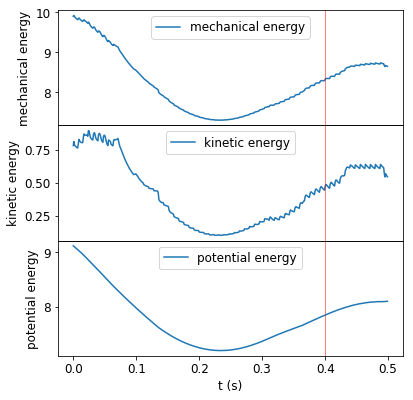

In [24]:
# Plot potential energy and kinematic energy
from utils import plotter
meArr = peArr + keArr
eArr = np.vstack([peArr, keArr])
eArr = np.vstack([eArr, meArr])

eArr = eArr[:,2000:2500]
contactTime = 2400
drawer1 = plotter(eArr, v_line=[contactTime-2000],
        timeStep = 1e-3,
        label=['potential energy', 'kinetic energy', 'mechanical energy'], 
        xlabel='t (s)', 
        ylabel='energy (J)', 
        fileName=savepath+'energy.png')
drawer1.multiTimePlot()

Compare control and simulation posture delay

In [ ]:
# Save trajectory to hardware
print(np.shape(posArr))
rollover_hardware_traj = ss.toHardwareTraj(posArr)
# bimanual_hardware_traj = posArr
print(np.shape(rollover_hardware_traj))
np.savetxt(savepath+"rollover_value.csv", rollover_hardware_traj, delimiter=",")
np.savetxt(savepath+"rollover_value_verify.csv", rollover_hardware_traj.T, delimiter=",")
# ss.downloadTraj(savepath+"rollover_value.csv")


In [ ]:
# Calculate summit torque
np.savetxt(savepath+"rollover_torque.csv", torqueArr, delimiter=",")

len = np.shape(torqueArr)[1]
currentArr = np.zeros([20, len])

def t2c28(x):
    # return math.sqrt(x)
    return 0.9286*x-0.05
def t2c64(x):
    return 0.875*x+0.1375
def t2c106(x):
    return 0.833*x-0.75

t2c28_v = np.vectorize(t2c28)
t2c64_v = np.vectorize(t2c64)
t2c106_v = np.vectorize(t2c106)

# l_hip_y
currentArr[0,:] = 4.1* np.ones([len])
currentArr[10,:] = 4.1* np.ones([len])
for i in range(1, 6):
    currentArr[i,:] = 5.2* np.ones([len])
    if i+10 == 11:
        currentArr[i+10,:] = 5.2* np.ones([len])
    else:
        currentArr[i+10,:] = np.absolute(t2c64_v(torqueArr[i+10,:]))
for i in range(6, 8):
    currentArr[i,:] = np.absolute(t2c64_v(torqueArr[i,:]))
    currentArr[i+10,:] = np.absolute(t2c64_v(torqueArr[i+10,:]))
for i in range(8, 10):
    currentArr[i,:] = np.absolute(t2c28_v(torqueArr[i,:]))
    currentArr[i+10,:] = np.absolute(t2c28_v(torqueArr[i+10,:]))

currentSum = np.sum(currentArr, axis=0)
currentSumArr = np.zeros([1,len])
currentSumArr[0,:] = currentSum

print(np.max(currentSum),np.min(currentSum))
from utils import plotter

drawer1 = plotter(currentSumArr, 
        timeStep = 1e-3,
        label=['current'], 
        xlabel='t (s)', 
        ylabel='current (A)', 
        fileName=savepath+'current.png')
drawer1.timePlot()

visualize contact pose

In [ ]:
m.visualizeConfig(forcePose)

Plot simulated result

do following command before screen capture

`sudo update-alternatives --config python3`

maximum force is 95.424602N


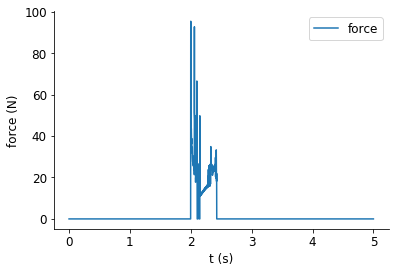

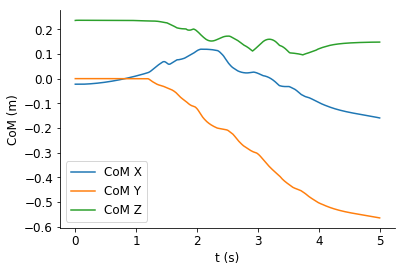

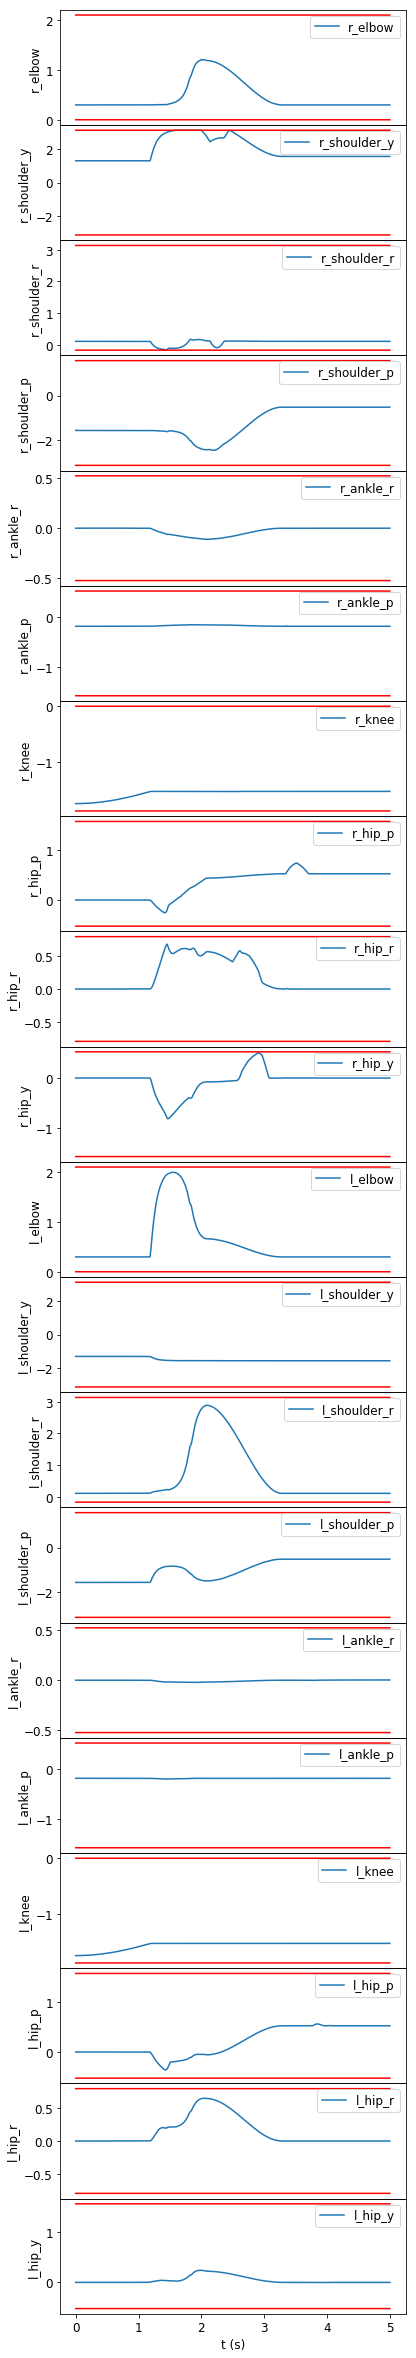

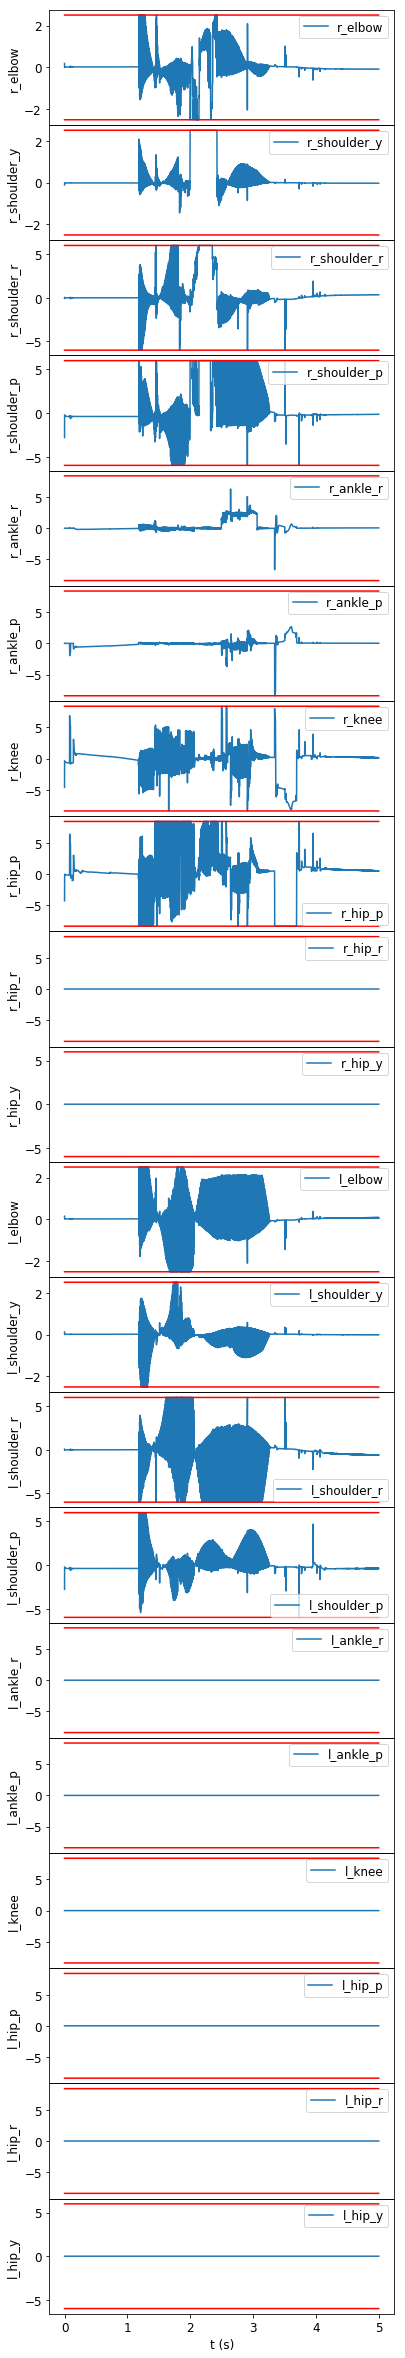

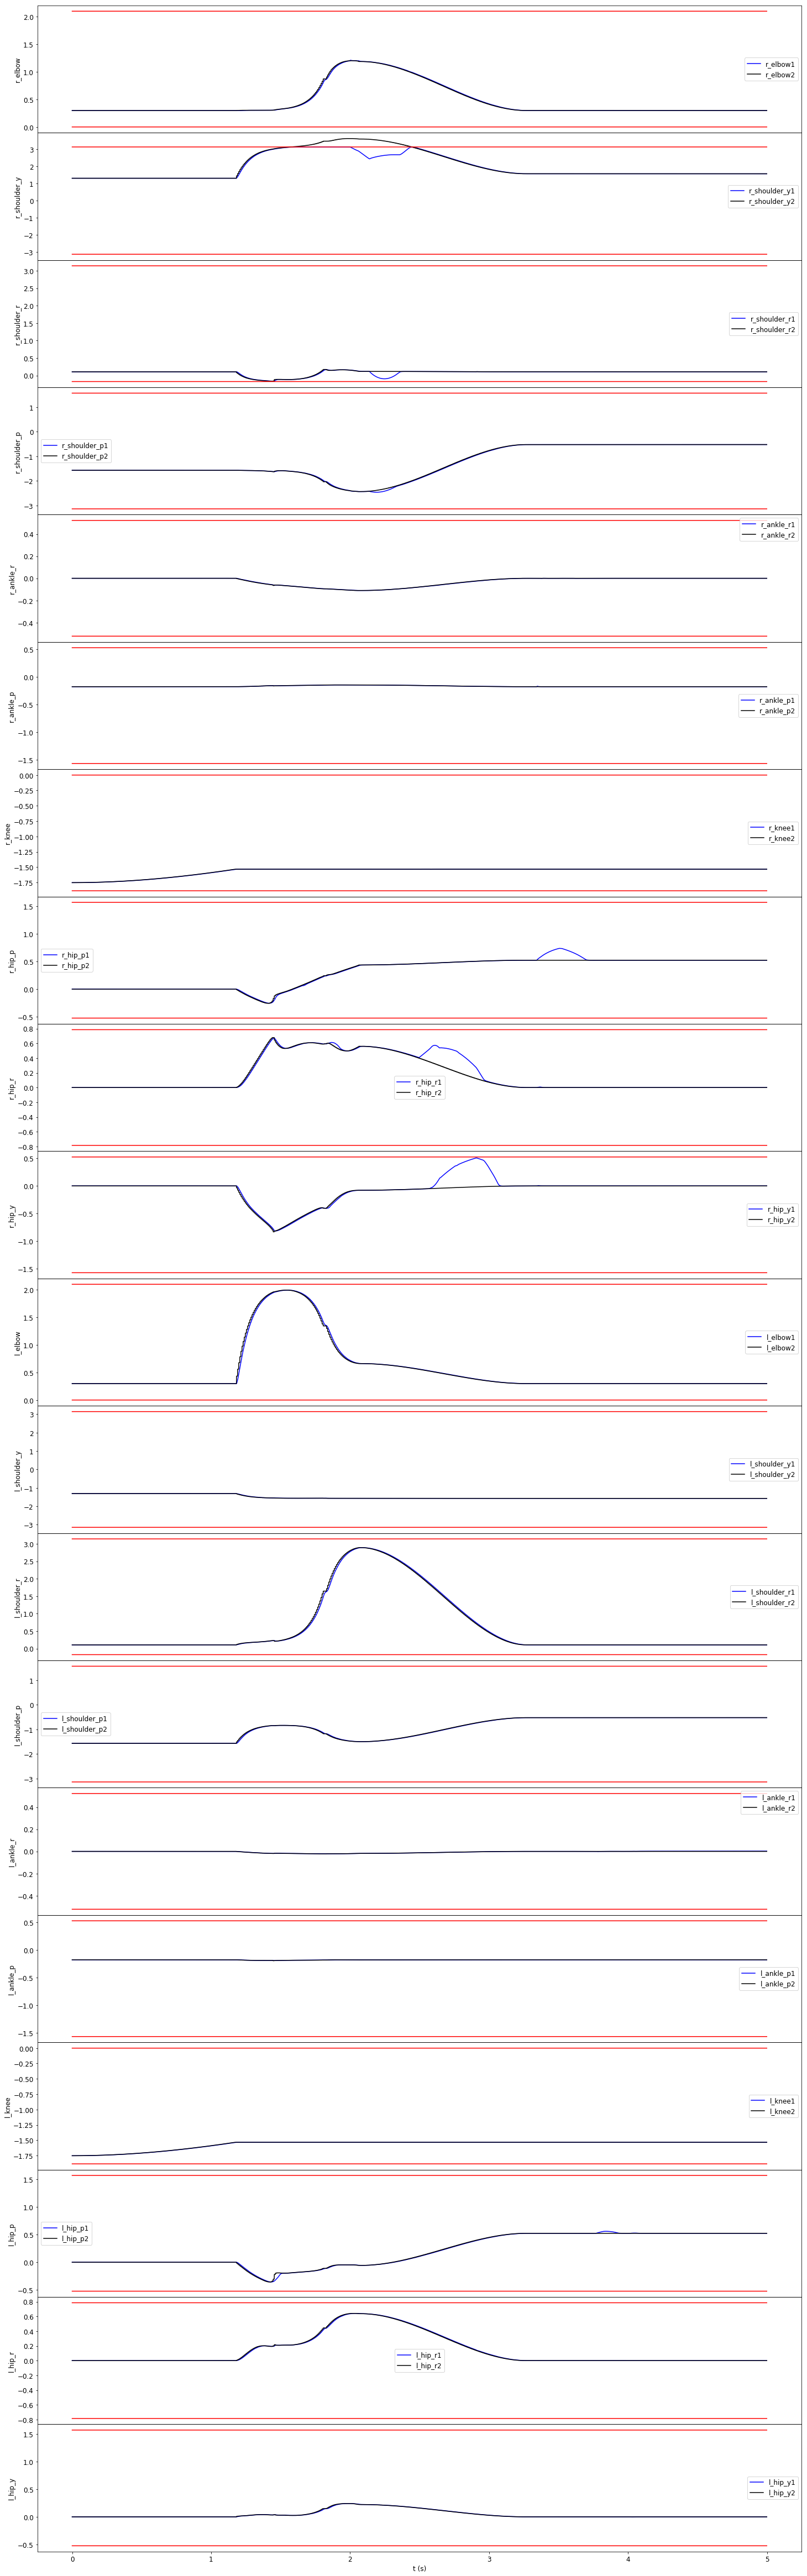

In [29]:

posInfo = []
posInfo.append(posArr)
posInfo.append(lower)
posInfo.append(upper)

torqueInfo = []
torqueInfo.append(torqueArr)
torqueInfo.append(torqueLower)
torqueInfo.append(torqueUpper)

cmpInfo = []
cmpInfo.append(posArr)
cmpInfo.append(tauArr)
cmpInfo.append(lower)
cmpInfo.append(upper)

ss.plot(forceArr,comArr,posInfo, torqueInfo,savepath, time_step, cmpInfo=cmpInfo)

In [ ]:
from simulator import HumanoidSimulator
from simple_planner import SimpleRolloverTrajWrapper

# rollover trajectory replay

In [ ]:
# replay encoder trajectory
ENCODER_DIR=savepath + '09_25_1/desired_trajectory.csv'

sss = HumanoidSimulator(horizon_length, display=True,timeStep=time_step, view='side')
sss.initPose(x0, nq, nv, na)

forceArr, comArr, posArr, torqueArr, qArr, forcePose, tauArr, peArr, keArr, contactTime, motorEArr, velArr= sss.replayEncoder(m,ENCODER_DIR, DIR=savepath)
meArr = peArr + keArr
np.savetxt(savepath+"09_25_1/force_array_rollover.csv", forceArr.T, delimiter=",")
np.savetxt(savepath+"09_25_1/com_array_rollover.csv", comArr.T, delimiter=",")
np.savetxt(savepath+"09_25_1/motor_energy_array_rollover.csv", motorEArr.T, delimiter=",")
np.savetxt(savepath+"09_25_1/mechanical_energy_array_rollover.csv", meArr.T, delimiter=",")

# bimanual trajectory replay

In [ ]:
# replay encoder trajectory
ENCODER_DIR=savepath + '09_25_2/desired_trajectory.csv'

sss = HumanoidSimulator(horizon_length, display=False,timeStep=time_step, view='side')
sss.initPose(x0, nq, nv, na)
forceArr, comArr, posArr, torqueArr, qArr, forcePose, tauArr, peArr, keArr, contactTime, motorEArr, velArr = sss.replayEncoder(m,ENCODER_DIR, DIR=savepath)
meArr = peArr + keArr
np.savetxt(savepath+"09_25_2/force_array_bimanual.csv", forceArr.T, delimiter=",")
np.savetxt(savepath+"09_25_2/com_array_bimanual.csv", comArr.T, delimiter=",")
np.savetxt(savepath+"09_25_2/motor_energy_array_bimanual.csv", motorEArr.T, delimiter=",")
np.savetxt(savepath+"09_25_2/mechanical_energy_array_bimanual.csv", meArr.T, delimiter=",")

In [ ]:
# Plot potential energy and kinematic energy
from utils import plotter
eArr = np.vstack([peArr, keArr])
eArr = np.vstack([eArr, meArr])
eArr = np.vstack([eArr, motorEArr])
# print(peArr[0,forceKnot], keArr[0,forceKnot])
# print(peArr[0,contactTime-1], keArr[0,contactTime-1])
# eArr = eArr[:,2000:2500]

drawer1 = plotter(eArr, v_line=[contactTime],
        timeStep = 1e-3,
        label=['potential energy', 'kinetic energy', 'mechanical energy', 'motor injection energy'], 
        xlabel='t (s)', 
        ylabel='energy (J)', 
        fileName=savepath+'energy.png')
drawer1.multiTimePlot()

In [ ]:
posInfo = []
posInfo.append(velArr)
posInfo.append(lower)
posInfo.append(upper)

torqueInfo = []
torqueInfo.append(torqueArr)
torqueInfo.append(torqueLower)
torqueInfo.append(torqueUpper)

cmpInfo = []
cmpInfo.append(posArr)
cmpInfo.append(tauArr)
cmpInfo.append(lower)
cmpInfo.append(upper)

sss.plot(forceArr,comArr,posInfo, torqueInfo,savepath, time_step, cmpInfo=cmpInfo)

### Generate Solidwork config files

In [ ]:
# q = qArr[:,1800]
# m.visualizeConfig(q)
# np.savetxt(savepath+"config_rollover.csv", q, delimiter=",")


In [ ]:

# from simple_planner import SimpleKneePlanner
# from rollover_planner import RolloverPlanner
# print(rolloverPlanner.x[:,-1])
# print(x0.T.tolist()[0])
# rolloverPlanner.saveConfig(x0.T.tolist()[0],savepath+'kneeling_config.xlsx')
print(x0.shape)
# m.visualizeConfig(x0[:nq])

# rolloverPlanner.readConfig(savepath+'config.xlsx')


In [ ]:
# from pinocchio.rpy import matrixToRpy, rpyToMatrix, rotate

In [ ]:
# m = rotate('z', np.pi /3).dot(rotate('y', np.pi / 5)).dot(rotate('x', np.pi / 7))
# print(np.pi/3,np.pi/5,np.pi/7)
# print(m)
# print(matrixToRpy(m))

In [ ]:
# rpy = np.array(list(range(3))) * np.pi / 2

In [ ]:
# rpyToMatrix(rpy)

In [ ]:
# matrixToRpy(rpyToMatrix(rpy))

In [ ]:
# matrixToRpy(m)

In [ ]:
# rpyToMatrix(matrixToRpy(m))

In [ ]:
# from visualizer import VisualModel
# pinocchio.switchToNumpyMatrix()
# v = VisualModel(display=True)
# x = v.q0.T.tolist()[0]
# print(rolloverPlanner.x[:,-1])

# rolloverPlanner.saveConfig(x,savepath+'kneeling_config.xlsx')
# v.q0 = np.matrix(rolloverPlanner.x[:,-1]).T
# v.q0[0] = 0.
# v.q0[1] = 0
# v.q0[2] = 0
# v.show()
# x = v.q0.T.tolist()[0]
# rolloverPlanner.saveConfig(x,savepath+'kneeling_config.xlsx')
# quat = np.asarray(v.q0[3:7].copy()).tolist()
# print(quat)
# # Convert quaternion to rpy
# vector = np.matrix([0, 0, 0, quat[0][0], quat[1][0], quat[2][0], quat[3][0]]).T
# print(vector)
# se3 = pinocchio.XYZQUATToSE3(vector)
# rpy = matrixToRpy(se3.rotation)
# print(rpy)


In [ ]:
# m = rotate('z', np.pi /2).dot(rotate('y', np.pi / 100)).dot(rotate('x', np.pi /3))
# print(np.pi/3,np.pi/5,np.pi/7)
# print(m)
# print(matrixToRpy(m))

# n = pinocchio.SE3.Identity()
# n.rotation = m
# o = pinocchio.SE3ToXYZQUAT(n)
# print(o)
# # v.q0[3:7]=o[3:7]
# # v.q0[0] -= 0.02639
# # v.q0[1] -= 0.
# # v.q0[2] -= 0.50958
# v.q0[0] = 0.0
# v.q0[1] = 0.
# v.q0[2] = 0.0
# v.show()
# v.show()


# quat = np.asarray(v.q0[3:7].copy()).tolist()
# print(quat)
# # Convert quaternion to rpy
# vector = np.matrix([0, 0, 0, quat[0][0], quat[1][0], quat[2][0], quat[3][0]]).T
# print(vector)
# se3 = pinocchio.XYZQUATToSE3(vector)
# rpy = matrixToRpy(se3.rotation)
# print(rpy)



In [ ]:
# import crocoddyl
# print(crocoddyl.__file__)